
### This notebook analyses data from Landsat 8 downloaded using USGS Earth Explorer. First, NDVI is calculated and unsupervised classification of spatial data into land and water is performed.

In [ ]:
from osgeo import gdal, gdal_array
import numpy as np
from matplotlib import pyplot as plt
from sklearn import cluster

## NDVI Calculation

In [2]:
def calculate_ndvi(nir_band, red_band):
    # Calculate NDVI
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return ndvi


In [3]:
# Open NIR and Red bands. Band 4 is NIR and band 3 is Red.
nir_ds = gdal.Open('dataset/LC09_L2SP_160077_20240130_20240131_02_T1/LC09_L2SP_160077_20240130_20240131_02_T1_SR_B4.TIF')
red_ds = gdal.Open('dataset/LC09_L2SP_160077_20240130_20240131_02_T1/LC09_L2SP_160077_20240130_20240131_02_T1_SR_B3.TIF')

if nir_ds is None or red_ds is None:
    print("Failed to open NIR or Red band file.")
else:    
    # Read band data
    nir_band = nir_ds.GetRasterBand(1).ReadAsArray().astype(np.float32)
    red_band = red_ds.GetRasterBand(1).ReadAsArray().astype(np.float32)

    # Calculate NDVI
    ndvi = calculate_ndvi(nir_band, red_band)

    # Save NDVI to a new GeoTIFF file
    driver = gdal.GetDriverByName('GTiff')
    output_file = 'ndvi.tif'
    ndvi_ds = driver.Create(output_file, nir_ds.RasterXSize, nir_ds.RasterYSize, 1, gdal.GDT_Float32)
    ndvi_ds.SetGeoTransform(nir_ds.GetGeoTransform())
    ndvi_ds.SetProjection(nir_ds.GetProjection())
    ndvi_ds.GetRasterBand(1).WriteArray(ndvi)
    ndvi_ds.FlushCache()
    ndvi_ds = None


/tmp/ipykernel_83700/2730247322.py:3: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir_band - red_band) / (nir_band + red_band)


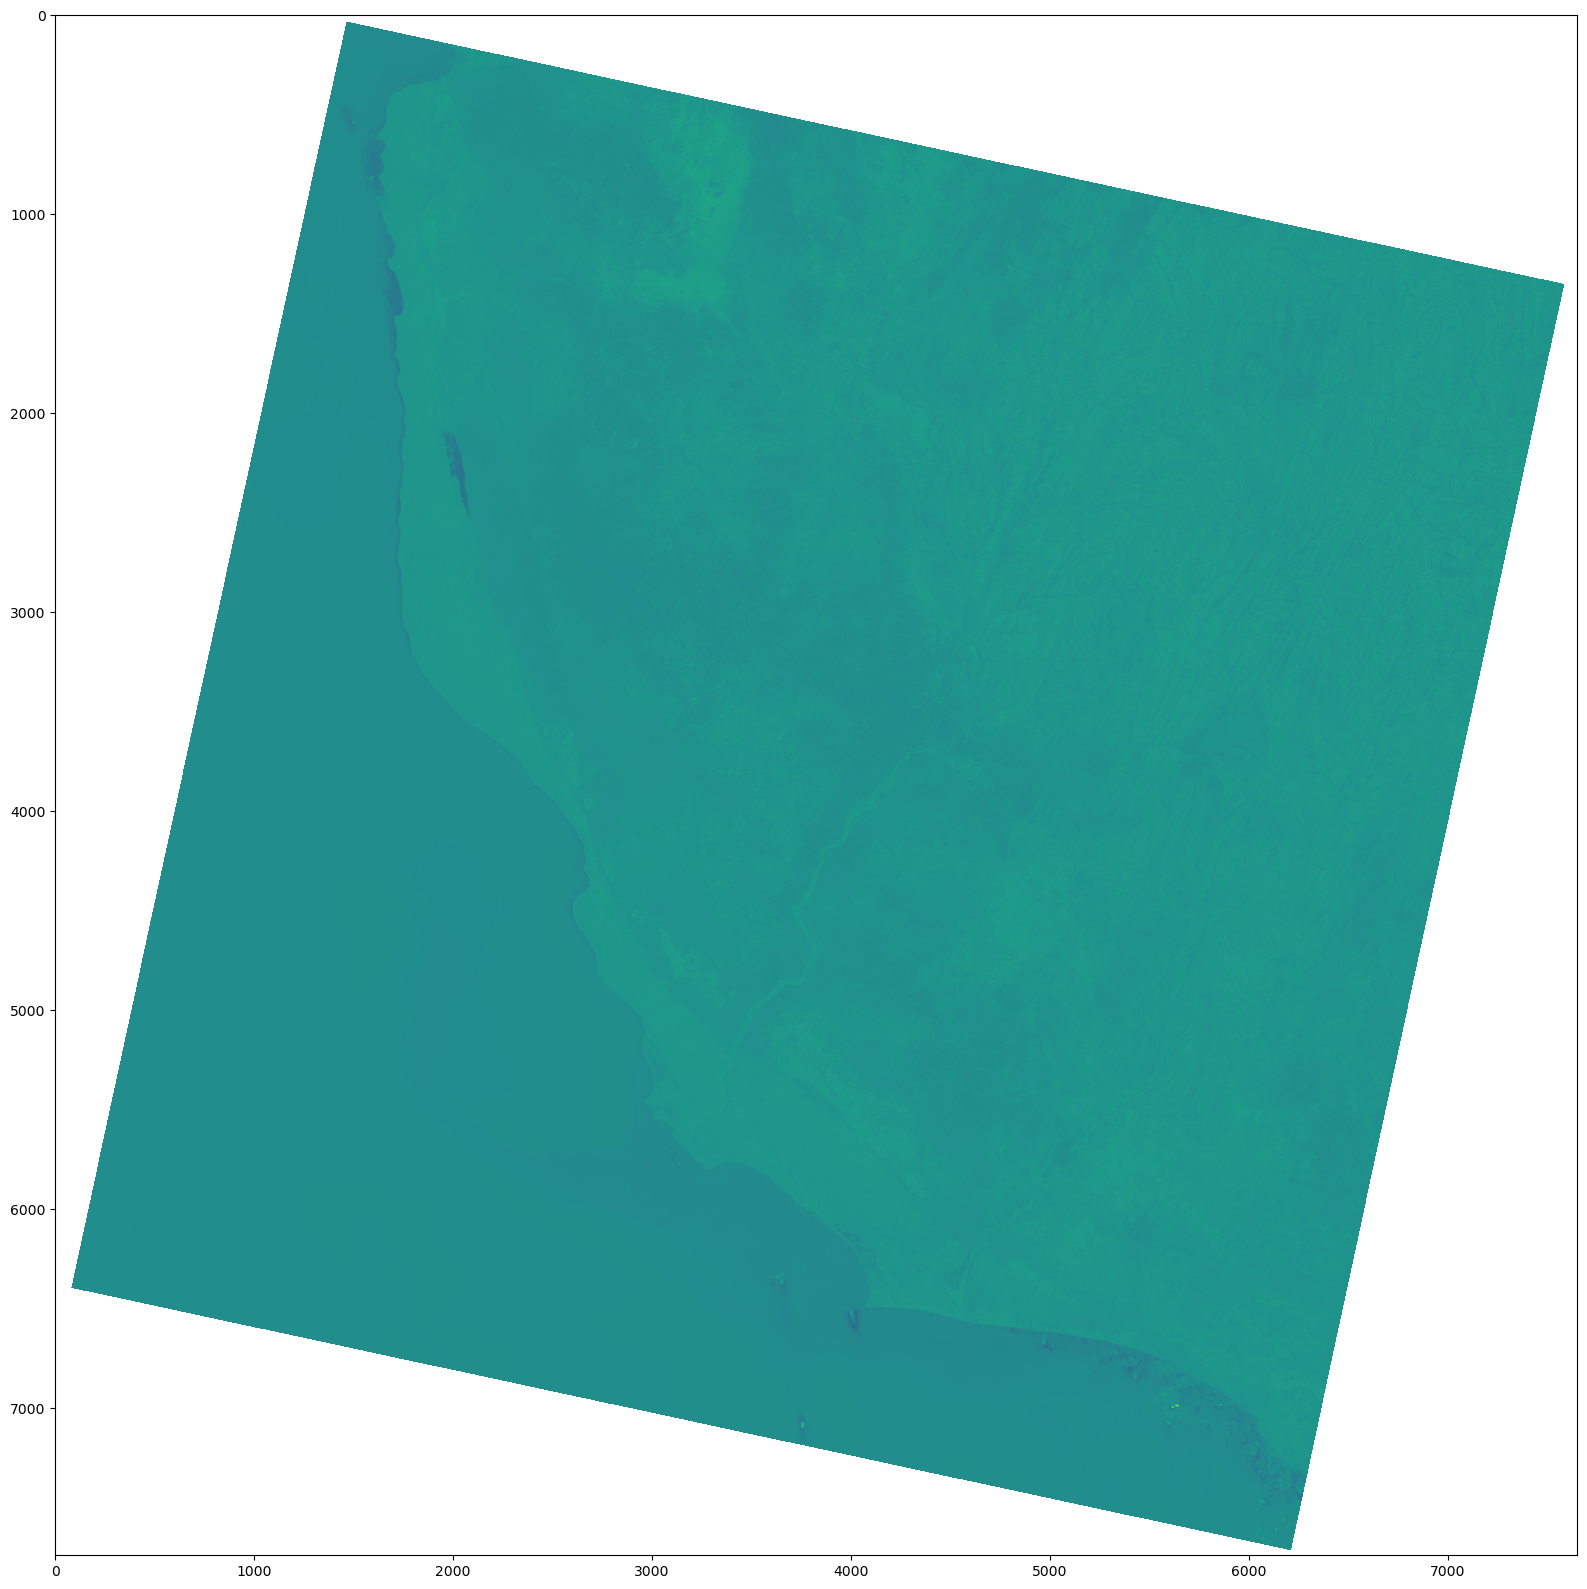

In [4]:
#Plot NDVI
plt.figure(figsize=(20,20))
plt.imshow(ndvi)
plt.show()


## Classification of land and water polygons

## Using Only Blue Band

In [5]:
blue_ds = gdal.Open('dataset/LC09_L2SP_160077_20240130_20240131_02_T1/LC09_L2SP_160077_20240130_20240131_02_T1_SR_B1.TIF', gdal.GA_ReadOnly)
blue_band = blue_ds.GetRasterBand(1).ReadAsArray().astype(np.float32)

In [ ]:
X = blue_band.reshape((-1,1))
k_means = cluster.KMeans(n_clusters=8)# No. of clusters=8
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(blue_band.shape)


/home/ani/mambaforge/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


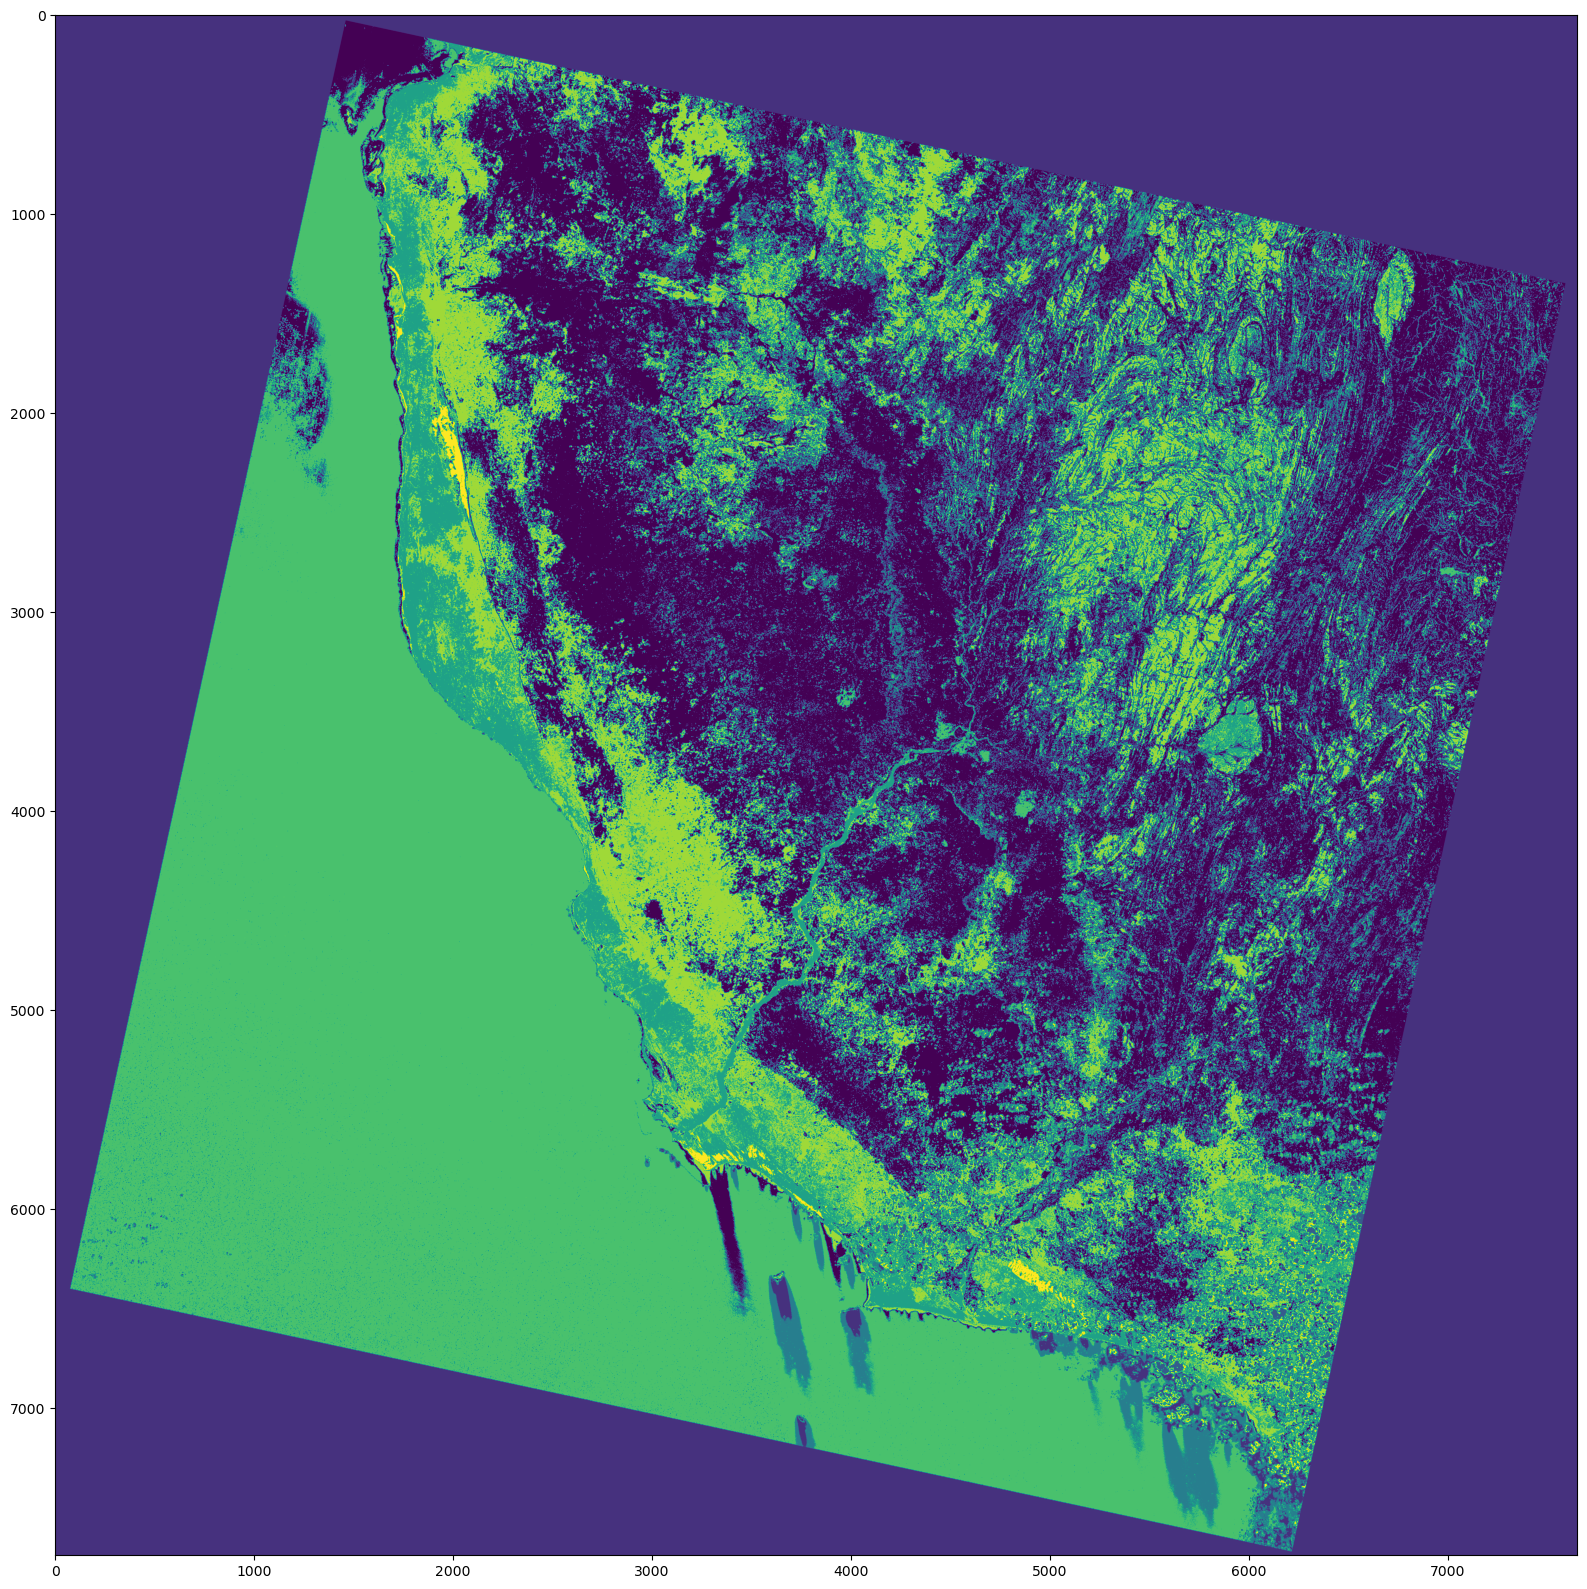

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster)
plt.show()


## Using All the Seven bands

In [14]:
num_band = 7
img_ds = gdal.Open('dataset/LC09_L2SP_160077_20240130_20240131_02_T1/LC09_L2SP_160077_20240130_20240131_02_T1_SR_B1.TIF', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, num_band),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

img.shape

In [17]:
for i in list(range(num_band)):
    band_ds = gdal.Open('dataset/LC09_L2SP_160077_20240130_20240131_02_T1/LC09_L2SP_160077_20240130_20240131_02_T1_SR_B'+str(i+1)+'.TIF', gdal.GA_ReadOnly)
    band = band_ds.GetRasterBand(1).ReadAsArray().astype(np.float32)
    img[:, :, i] = band
    

In [18]:
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
print (img.shape)
print (new_shape)

X = img[:, :, :13].reshape(new_shape)
print (X.shape)

(7741, 7651, 7)
(59226391, 7)
(59226391, 7)


In [21]:
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

(7741, 7651)


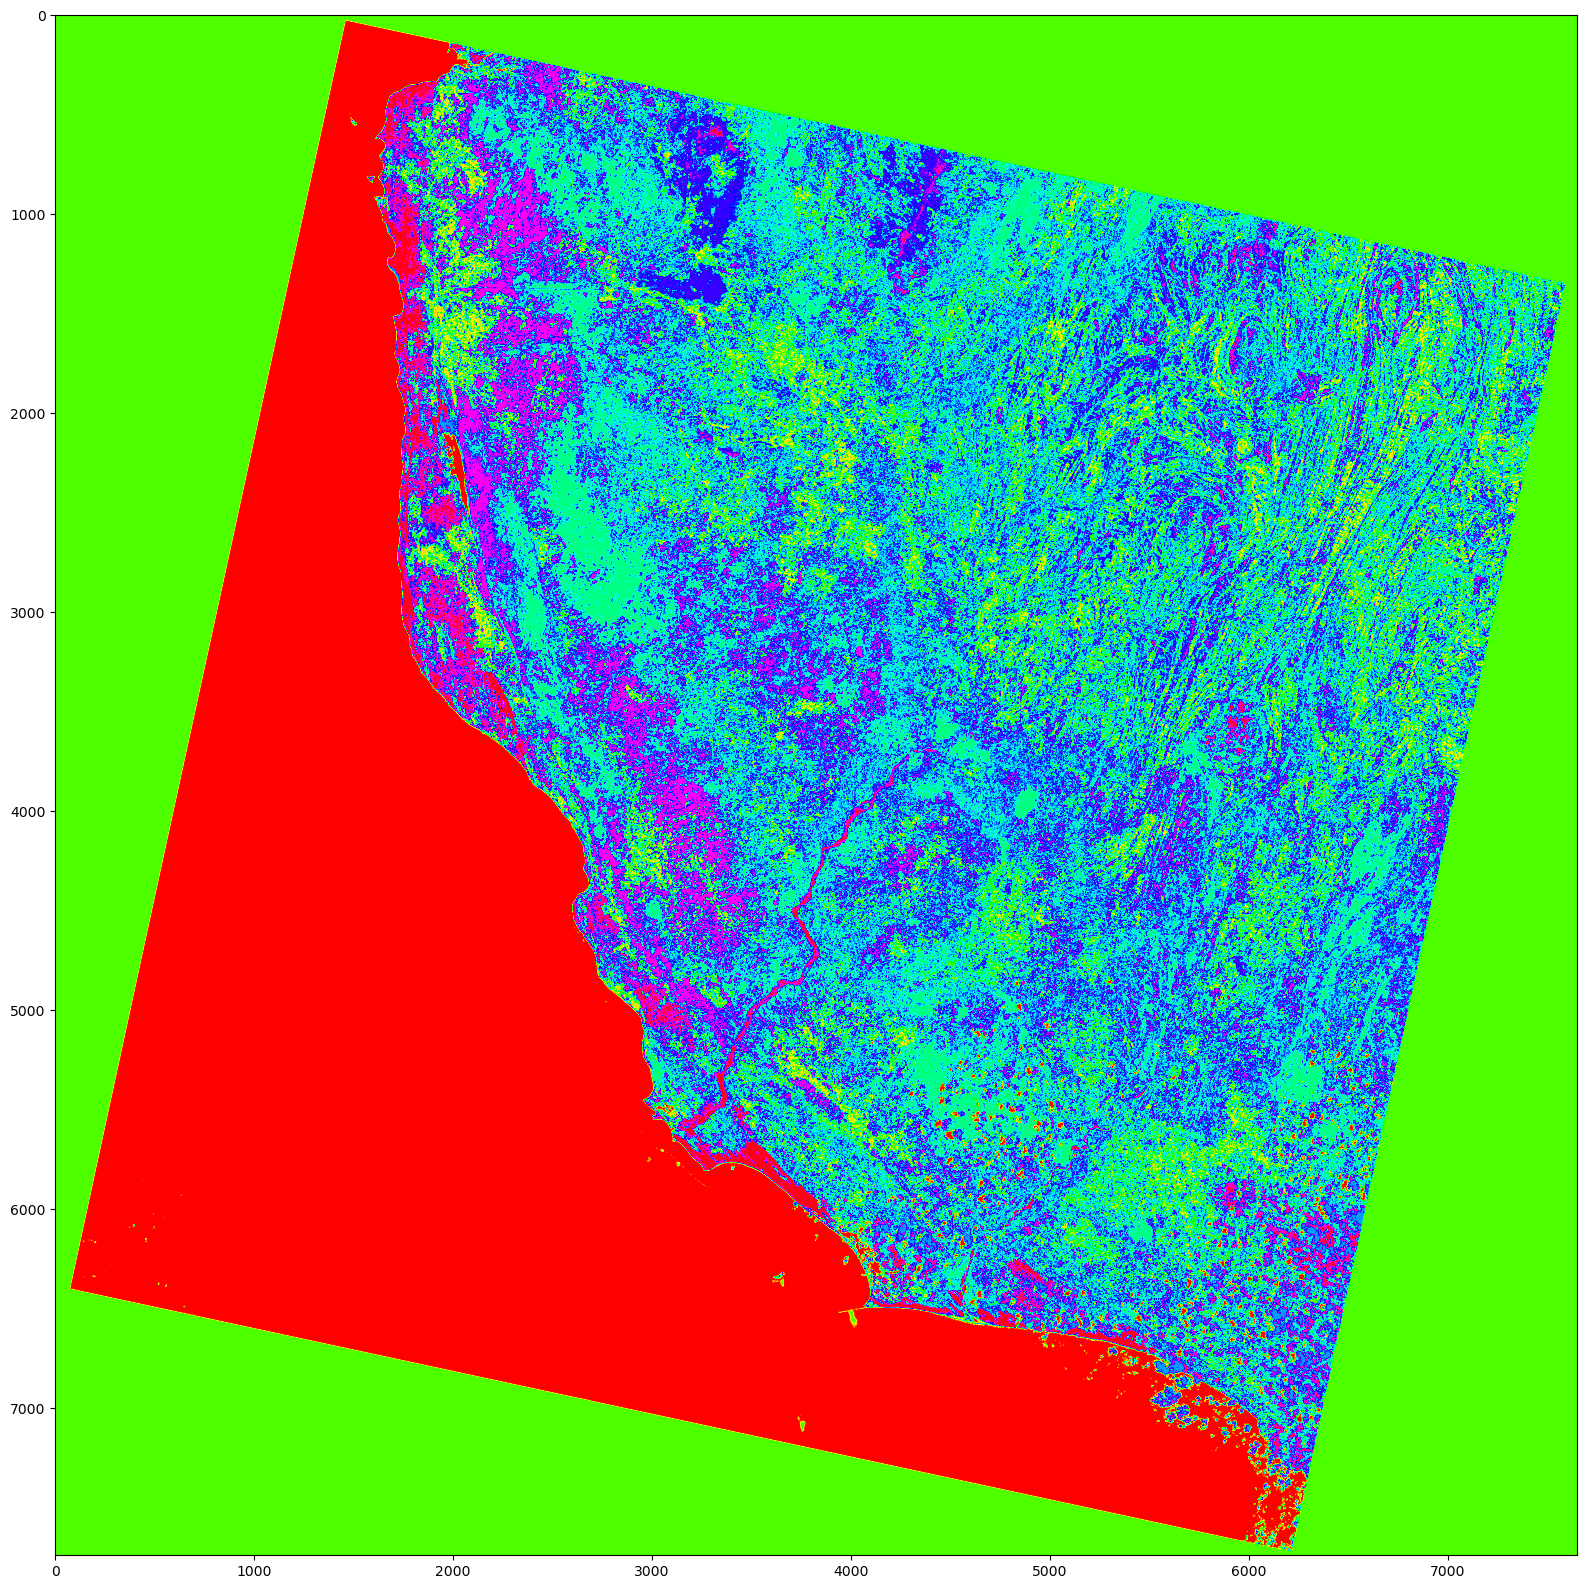

In [23]:
print (X_cluster.shape)

plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")

plt.show()